# 1. Initializations and Dataset Download

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omaratef3221
Your Kaggle Key: ··········


100%|██████████| 696M/696M [00:06<00:00, 112MB/s]


# 2. Imports

Lets start by getting all our imports. Additionally, we will check if TensorFlow is using the GPU or not. If everything is installed correctly, TensorFlow will use the GPU automatically and in Colab everything is installed for you.

In [2]:
import tensorflow as tf # TensorFlow main library
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Main image data generator to read the images
from tensorflow.keras import models, layers # Models layer e.g. Dense, Convolutions, etc.
import matplotlib.pyplot as plt # Plotting to plot train progress
from sklearn.metrics import classification_report # For Evaluation
import pandas as pd # Pandas for data analysis
import numpy as np # Analysis for numbers
import os # Interacting with the operating system

print(tf.config.list_physical_devices('GPU')) # Checking if tensorflow is using the GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 3. Reading Data Paths
The following code will be going through a nested directory structure where images are stored within subdirectories, each directory is representing a specific label (category). It constructs a list of the file paths for these images and their corresponding labels. Then, it creates a pandas DataFrame containing this information, which is useful for further data processing. Keep in mind that we will read all the data and then we will split it again to train, validation and testing.

In [3]:
image_path = [] # Empty array where we will fill the paths of the images
labels = [] # Empty array where we will fill the labes of the images

for i in os.listdir("/content/animal-faces/afhq/"): # Looping through the first directory which has the train and val images
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"): # Looping through the first directory which has the labels folders
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"): # Looping through all the images of this label
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}") # Append/Put this image path in the list to read it later

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels

print("Data Distribution: ")
print(data_df["labels"].value_counts())

print()
data_df.head() # Visualizing the first 5 rows


Data Distribution: 
cat     5653
dog     5239
wild    5238
Name: labels, dtype: int64



,image_paths,labels
0,/content/animal-faces/afhq/train/wild/flickr_w...,wild
1,/content/animal-faces/afhq/train/wild/flickr_w...,wild
2,/content/animal-faces/afhq/train/wild/flickr_w...,wild
3,/content/animal-faces/afhq/train/wild/flickr_w...,wild
4,/content/animal-faces/afhq/train/wild/pixabay_...,wild


# 4. Data Split

Now lets split the dataset into training, validation and testing. Here we will be using it in a bit different way since we will be reading the image paths from the dataframe so better we split the dataframe directly and then read the images. We will do that by getting a random sample of 70% from our data using `data_df.sample(frac=0.7,random_state=7)` then we will create a new variable of test dataset which we will drop from it the 70% of the train which means that it will be 30% of the data which is the rest of the data using `data_df.drop(train.index)`. Then we will do the same between testing to create validation which will be 50% of the data which means the final split we have is the following:

*   Training: 70%
*   Validation: 15%
*   Testing: 15%



In [4]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

batch_size = 16  # Adjust based on your RAM capacity

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='image_paths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' for binary classification
)

val_generator = val_datagen.flow_from_dataframe(
    val,
    x_col='image_paths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' for binary classification
)

test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='image_paths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' for binary classification
)

Found 11291 validated image filenames belonging to 3 classes.
Found 2420 validated image filenames belonging to 3 classes.
Found 2419 validated image filenames belonging to 3 classes.


In [6]:
model = models.Sequential() # The type of the model we will build is called sequential
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 73984)             0

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=10,
                    validation_data=val_generator)

Epoch 1/10
706/706 [==============================] - 48s 58ms/step - loss: 0.5116 - accuracy: 0.7937 - val_loss: 0.1736 - val_accuracy: 0.9438
Epoch 2/10
706/706 [==============================] - 35s 49ms/step - loss: 0.2157 - accuracy: 0.9227 - val_loss: 0.1172 - val_accuracy: 0.9587
Epoch 3/10
706/706 [==============================] - 35s 49ms/step - loss: 0.1319 - accuracy: 0.9531 - val_loss: 0.1071 - val_accuracy: 0.9632
Epoch 4/10
706/706 [==============================] - 36s 51ms/step - loss: 0.0998 - accuracy: 0.9645 - val_loss: 0.1120 - val_accuracy: 0.9661
Epoch 5/10
706/706 [==============================] - 38s 54ms/step - loss: 0.0852 - accuracy: 0.9685 - val_loss: 0.0932 - val_accuracy: 0.9736
Epoch 6/10
706/706 [==============================] - 35s 50ms/step - loss: 0.0558 - accuracy: 0.9791 - val_loss: 0.1131 - val_accuracy: 0.9632
Epoch 7/10
706/706 [==============================] - 34s 48ms/step - loss: 0.0423 - accuracy: 0.9853 - val_loss: 0.1433 - val_accuracy:

In [30]:
test_results = model.evaluate(test_generator)
print()
for indx, metric in enumerate(model.metrics_names):
  print("Testing ",metric, ": ", round(test_results[indx], 4))

print()
predictions = model.predict(test_generator)
print(classification_report(test_generator.classes,
                            predictions.argmax(axis=-1),
                            target_names=test_generator.class_indices))

152/152 [==============================] - 6s 36ms/step - loss: 0.2163 - accuracy: 0.9446

Testing  loss :  0.2163
Testing  accuracy :  0.9446

152/152 [==============================] - 5s 32ms/step
              precision    recall  f1-score   support

         cat       0.37      0.37      0.37       858
         dog       0.33      0.32      0.32       800
        wild       0.30      0.32      0.31       761

    accuracy                           0.34      2419
   macro avg       0.33      0.33      0.33      2419
weighted avg       0.34      0.34      0.34      2419



# 9. Plotting Training Progress

Let's plot the training and validation progress through out the EPOCHS using the history variable we created before and assigned to it the training progress. The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!

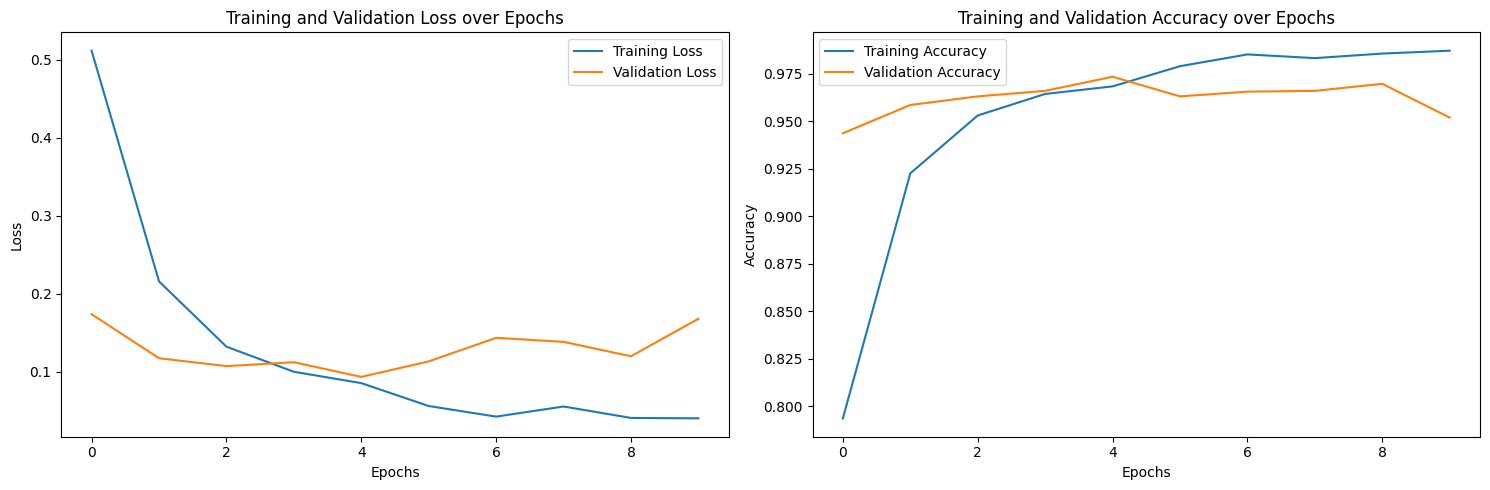

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()